In [16]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy

import numpy as np
from scipy import ndimage

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.constants import G
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import matplotlib.pyplot as plt
from matplotlib import colors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Cython Tutorial from Adrian Price-Whelan

- See: https://github.com/adrn/cython-tutorial/blob/main/1-notebook/1-notebook.ipynb

In [17]:
# The unit system we'll use:
units = [u.Myr, u.kpc, u.Msun]

In [18]:
# parameters of the gravitational potential
m = 1E11 # Msun
c = 1. # kpc

# value of G in our unit system
_G = G.decompose(units).value

In [23]:
def hernquist_acceleration(xyz, G, m, c):
    """Acceleration under the Hernquist potential."""
    r = np.sqrt(xyz[0]**2 + xyz[1]**2 + xyz[2]**2)
    dPhi_dr = G * m / (r + c) ** 2
    return -dPhi_dr * xyz / r

- Now we'll implement the Leapfrog integration scheme. We need to specify initial conditions, a timestep, and a number of steps to run for. We'll return the time, position, and velocity arrays for the numerical orbit:

In [24]:
def leapfrog_hernquist(x0, v0, dt, n_steps, hernquist_args=()):
    
    # ensure that the initial conditions are arrays
    x0 = np.array(x0)
    v0 = np.array(v0)
    
    # Create arrays to store positions and velocities at all times
    x = np.zeros((n_steps + 1, 3))
    v = np.zeros((n_steps + 1, 3))
    t = np.zeros(n_steps + 1)
    
    x[0] = x0
    v[0] = v0
    
    # Increment velocity by 1/2 step 
    v_iminus1_2 = v0 + dt/2. * hernquist_acceleration(x0, *hernquist_args)
    for i in range(1, n_steps+1):
        x[i] = x[i-1] + v_iminus1_2 * dt # full step
        
        a_i = hernquist_acceleration(x[i], *hernquist_args)
        v[i] = v_iminus1_2 + a_i * dt/2. # half step
        v_iminus1_2 = v[i] + a_i * dt/2. # another half step
        
        t[i] = t[i-1] + dt
    
    return t, x, v

- Define the initial position and velocity; also the timestep and number of steps

In [25]:
x0 = [5., 1, 1]
v0 = [0.05, 0.05, 0.10]
dt = 1.
n_steps = 100000

t, x, v = leapfrog_hernquist(
    x0=x0, v0=v0, dt=dt, n_steps=n_steps, hernquist_args=(_G, m, c))

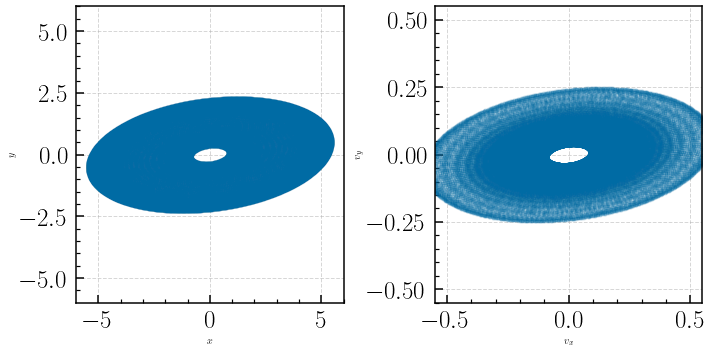

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

axes[0].plot(x[:,0], x[:,1], marker='.', linestyle='none', alpha=0.05)
axes[0].set_xlim(-6, 6)
axes[0].set_ylim(-6, 6)

axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')

axes[1].plot(v[:,0], v[:,1], marker='.', linestyle='none', alpha=0.1)
axes[1].set_xlim(-0.55, 0.55)
axes[1].set_ylim(-0.55, 0.55)

axes[1].set_xlabel('$v_x$')
axes[1].set_ylabel('$v_y$')

fig.tight_layout()

In [30]:
%%time
_ = leapfrog_hernquist(x0=x0, v0=v0,
                       dt=dt, n_steps=n_steps, 
                       hernquist_args=(_G, m, c))

CPU times: user 1.6 s, sys: 15.5 ms, total: 1.62 s
Wall time: 1.77 s


### Cython in IPython

In [31]:
%load_ext Cython

- Using the exactly same code

In [32]:
%%cython

import numpy as np

# abbreviated function name for laziness...
def acc_cy1(xyz, G, m, c):
    r = np.sqrt(xyz[0]**2 + xyz[1]**2 + xyz[2]**2)
    dPhi_dr = G * m / (r + c)**2
    return -dPhi_dr * xyz / r

# and another abbreviated function name for laziness...
def leapfrog_cy1(x0, v0, dt, n_steps, hernquist_args=()):
   
    # ensure that the initial conditions are arrays
    x0 = np.array(x0)
    v0 = np.array(v0)
    
    # Create arrays to store positions and velocities at all times
    x = np.zeros((n_steps+1, 3))
    v = np.zeros((n_steps+1, 3))
    t = np.zeros(n_steps+1)
    
    x[0] = x0
    v[0] = v0
    
    # Increment velocity by 1/2 step 
    v_iminus1_2 = v0 + dt/2. * acc_cy1(x0, *hernquist_args)
    for i in range(1, n_steps+1):
        x[i] = x[i-1] + v_iminus1_2 * dt # full step
        
        a_i = acc_cy1(x[i], *hernquist_args)
        v[i] = v_iminus1_2 + a_i * dt/2. # half step
        v_iminus1_2 = v[i] + a_i * dt/2. # another half step
        
        t[i] = t[i-1] + dt
    
    return t, x, v

In [33]:
%%time
leapfrog_cy1(x0=x0, v0=v0,
             dt=dt, n_steps=n_steps, 
             hernquist_args=(_G, m, c))

CPU times: user 1.64 s, sys: 25.5 ms, total: 1.67 s
Wall time: 1.72 s


(array([0.0000e+00, 1.0000e+00, 2.0000e+00, ..., 9.9998e+04, 9.9999e+04,
        1.0000e+05]),
 array([[ 5.        ,  1.        ,  1.        ],
        [ 5.04436256,  1.04887251,  1.09887251],
        [ 5.07776184,  1.09546543,  1.19535676],
        ...,
        [-1.82348755,  1.91462223,  4.7637719 ],
        [-1.89626985,  1.88136212,  4.70713224],
        [-1.96521888,  1.84429888,  4.64097721]]),
 array([[ 0.05      ,  0.05      ,  0.1       ],
        [ 0.03888092,  0.04773272,  0.09767838],
        [ 0.0280524 ,  0.0454394 ,  0.09522554],
        ...,
        [-0.07459273, -0.0313592 , -0.05191001],
        [-0.07086567, -0.03516167, -0.06139735],
        [-0.06691715, -0.0389701 , -0.07095343]]))

- Use Cython's "annotate" feature to look at what lines hit the Python layer (and thus slow us down).

In [34]:
%%cython --annotate

import numpy as np

def acc_cy1(xyz, G, m, c):
    r = np.sqrt(xyz[0]**2 + xyz[1]**2 + xyz[2]**2)
    dPhi_dr = G * m / (r + c)**2
    return -dPhi_dr * xyz / r

def leapfrog_cy1(x0, v0, dt, n_steps, hernquist_args=()):
   
    # ensure that the initial conditions are arrays
    x0 = np.array(x0)
    v0 = np.array(v0)
    
    # Create arrays to store positions and velocities at all times
    x = np.zeros((n_steps+1, 3))
    v = np.zeros((n_steps+1, 3))
    t = np.zeros(n_steps+1)
    
    x[0] = x0
    v[0] = v0
    
    # Increment velocity by 1/2 step 
    v_iminus1_2 = v0 + dt/2. * acc_cy1(x0, *hernquist_args)
    for i in range(1, n_steps+1):
        x[i] = x[i-1] + v_iminus1_2 * dt # full step
        
        a_i = acc_cy1(x[i], *hernquist_args)
        v[i] = v_iminus1_2 + a_i * dt/2. # half step
        v_iminus1_2 = v[i] + a_i * dt/2. # another half step
        
        t[i] = t[i-1] + dt
    
    return t, x, v

In [35]:
%%cython --annotate

import numpy as np
cimport numpy as np # access to numpy from Cython layer

# this is like #include <math.h>, but defines the functions in Cython
from libc.math cimport sqrt

def acc_cy2(np.ndarray[np.float64_t, ndim=1] xyz, double G, double m, double a):
    cdef:
        double r
        double dPhi_dr
        np.ndarray[np.float64_t, ndim=1] a_xyz = np.zeros(3, np.float64)
        
    r = sqrt(xyz[0]**2 + xyz[1]**2 + xyz[2]**2)
    dPhi_dr = G * m / (r + a)**2
    
    a_xyz[0] = -dPhi_dr * xyz[0] / r
    a_xyz[1] = -dPhi_dr * xyz[1] / r
    a_xyz[2] = -dPhi_dr * xyz[2] / r
    
    return a_xyz

- Reasons why still many lines are yellow:
    - Many of the lines call "RaiseBufferIndexError". This is because whenever you access the index of a variable from Python, it checks whether the index is valid given the size of the array. This is a nice feature, but adds quite a bit of overhead in the code if you are doing array access a lot.
    
- We can turn of bounds checking using a special decorator. While we're at it, we'll turn off a few other checks - see the cython compiler directives for a full list of things you can control:

In [36]:
%%cython --annotate

import numpy as np # access to Numpy from Python layer
cimport numpy as np # access to Numpy from Cython layer

# this is like #include <math.h>, but defines the functions in Cython
from libc.math cimport sqrt

cimport cython

@cython.boundscheck(False) # won't check that index is in bounds of array
@cython.wraparound(False) # array[-1] won't work
@cython.nonecheck(False) # variables are never set to None
@cython.cdivision(True) # don't protect against dividing by zero
def acc_cy3(np.ndarray[np.float64_t, ndim=1] xyz, double G, double m, double a):
    cdef:
        double r
        double dPhi_dr
        np.ndarray[np.float64_t, ndim=1] a_xyz = np.zeros(3, np.float64)
        
    r = sqrt(xyz[0]**2 + xyz[1]**2 + xyz[2]**2)
    dPhi_dr = G * m / (r + a)**2
    
    a_xyz[0] = -dPhi_dr * xyz[0] / r
    a_xyz[1] = -dPhi_dr * xyz[1] / r
    a_xyz[2] = -dPhi_dr * xyz[2] / r
    
    return a_xyz

- To make this function pure C, we will:
    - make this a cdef function (only accessible from Cython)
    - pass in a pre-defined array to store the acceleration values

In [38]:
%%cython --annotate

import numpy as np # access to Numpy from Python layer
cimport numpy as np # access to Numpy from Cython layer

# this is like #include <math.h>, but defines the functions in Cython
from libc.math cimport sqrt

cimport cython

@cython.boundscheck(False) # won't check that index is in bounds of array
@cython.wraparound(False) # array[-1] won't work
@cython.nonecheck(False) # variables are never set to None
@cython.cdivision(True) # don't protect against dividing by zero
cdef void acc_cy4(np.ndarray[np.float64_t, ndim=1] xyz, double G, double m, double a,
                  np.ndarray[np.float64_t, ndim=1] a_xyz):
    cdef:
        double r
        double dPhi_dr
        
    r = sqrt(xyz[0]**2 + xyz[1]**2 + xyz[2]**2)
    dPhi_dr = G * m / (r + a)**2
    
    a_xyz[0] = -dPhi_dr * xyz[0] / r
    a_xyz[1] = -dPhi_dr * xyz[1] / r
    a_xyz[2] = -dPhi_dr * xyz[2] / r

- The above function definition still expects an array passed in by value. 
- If we truly want to optimize the hell out of this function, we instead want to pass in be reference using a special Numpy/Cython type called a **memoryview**. 
    - A `memoryview` is like a **pointer to a point in memory**, but allows easy access to the data behind Numpy arrays:

In [39]:
%%cython --annotate

import numpy as np # access to Numpy from Python layer
cimport numpy as np # access to Numpy from Cython layer

# this is like #include <math.h>, but defines the functions in Cython
from libc.math cimport sqrt

cimport cython

@cython.boundscheck(False) # won't check that index is in bounds of array
@cython.wraparound(False) # array[-1] won't work
@cython.nonecheck(False) # variables are never set to None
@cython.cdivision(True) # don't protect against dividing by zero
cdef void acc_cy5(double[::1] xyz, double G, double m, double a,
                  double[::1] a_xyz):
    cdef:
        double r
        double dPhi_dr
        
    r = sqrt(xyz[0]**2 + xyz[1]**2 + xyz[2]**2)
    dPhi_dr = G * m / (r + a)**2
    
    a_xyz[0] = -dPhi_dr * xyz[0] / r
    a_xyz[1] = -dPhi_dr * xyz[1] / r
    a_xyz[2] = -dPhi_dr * xyz[2] / r

In [40]:
%%cython --annotate
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True

import numpy as np # access to Numpy from Python layer
cimport numpy as np # access to Numpy from Cython layer
np.import_array()

# this is like #include <math.h>, but defines the functions in Cython
from libc.math cimport sqrt

cimport cython

cdef void acc_cy6(double[::1] xyz, double G, double m, double a,
                  double[::1] a_xyz):
    cdef:
        double r
        double dPhi_dr
        
    r = sqrt(xyz[0]**2 + xyz[1]**2 + xyz[2]**2)
    dPhi_dr = G * m / (r + a)**2
    
    a_xyz[0] = -dPhi_dr * xyz[0] / r
    a_xyz[1] = -dPhi_dr * xyz[1] / r
    a_xyz[2] = -dPhi_dr * xyz[2] / r
    
cpdef leapfrog_cy6(x0, v0, double dt, int n_steps, hernquist_args=()):
    cdef:
        # define memoryview's for initial conditions
        double[::1] _x0 = np.array(x0, np.float64)
        double[::1] _v0 = np.array(v0, np.float64)
    
        # Create arrays to store positions and velocities at all times
        double[:,::1] x = np.zeros((n_steps+1, 3), np.float64) # 2d arrays - note the [:,::1]
        double[:,::1] v = np.zeros((n_steps+1, 3), np.float64)
        double[::1] t = np.zeros(n_steps+1, np.float64)
        
        # Explicitly type the iteration variable 
        int i, k
        
        # placeholder for acceleration values
        double[::1] a_i = np.zeros(3) 
        
        # placeholder for velocity incremented by 1/2 step
        double[::1] v_iminus1_2 = np.zeros(3) 
        
        # explicitly typed and defined parameters
        double G = float(hernquist_args[0])
        double m = float(hernquist_args[1])
        double c = float(hernquist_args[2])        
    
    # get the acceleration at the initial position
    acc_cy6(_x0, G, m, c, a_i)
    
    # if i is cython typed, this will be a much more efficient C loop
    for k in range(3):
        x[0,k] = _x0[k]
        v[0,k] = _v0[k]
    
        # Increment velocity by 1/2 step 
        v_iminus1_2[k] = _v0[k] + dt/2. * a_i[k]
        
    for i in range(1, n_steps+1):
        for k in range(3):
            x[i,k] = x[i-1,k] + v_iminus1_2[k] * dt # full step
        
        acc_cy6(x[i], G, m, c, a_i)
        
        for k in range(3):
            v[i,k] = v_iminus1_2[k] + a_i[k] * dt/2. # half step
            v_iminus1_2[k] = v[i,k] + a_i[k] * dt/2. # another half step
        
        t[i] = t[i-1] + dt
    
    # convert from memoryview to array
    return np.array(t), np.array(x), np.array(v)

In [42]:
%%time
t_cy, x_cy, v_cy = leapfrog_cy6(x0=x0, v0=v0,
                                dt=dt, n_steps=n_steps, 
                                hernquist_args=(_G, m, c))

CPU times: user 6.52 ms, sys: 2.62 ms, total: 9.15 ms
Wall time: 8.22 ms


In [43]:
np.get_include()

'/usr/local/lib/python3.8/site-packages/numpy/core/include'